This notebook deals with an academic task connected with uplifting modelling.

The task is to maximize e-commerce store profits during an upcoming marketing campaign. Two databases are available:
1. The first consisting of 10 000 customers and containing:
 - customer information (age, education etc.)
 - binary variable indicating if a customer received advertisement offer
 - binary variable indicating is a customer purchased a product
2. The second (the target database) consisting of 100 000 clients and containing only information about the customers (no binary variables)

The goal is to identify the customers from the target database to whom the advertisement offer should be sent in order to maximize the store profit.

Assumptions: 
- average sales revenue is 100
- contact with the customer costs 10

Content
1. Data cleaning 
2. The first dataset analysis
3. Selecting the best method for predicting customers behaviour
4. Uplifting modelling

### 1. Data cleaning 

Datasets have _.txt_ extension. Unreadable characters are replaced, age and spent money variables are changed to categorical type. A new column is added (stan) which combines "wysylka_oferty" and "zakup" columns. Because the data is in Polish below is translation:
- wiek - age
- plec - sex
- wyksztalcenie - education
- miejsce - city (town, country, smalltown etc)
- kwota - amount of money a customer spent
- wojewodztwo - voivodeship
- wysylka_oferty - advertisement offer (sent - 1, not sent - 0 )
- zakup - purchase 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('klienci.txt', sep=",", header=0,encoding='unicode_escape',index_col='numer')
data['wojewodztwo']=data['wojewodztwo'].str.replace('³','l').str.replace('¹','a').str.replace('ó','o').str.replace('ê','e')

In [3]:
#function for age transformation
def wiek_kategorie(x):
    if x>=18 and x<=26:
        return 1
    elif x>26 and x<=30:
        return 2
    elif x>30 and x<=40:
        return 3
    elif x>40 and x<=50:
        return 4
    elif x>50 and x<=65:
        return 5
    else:
        return 6

#function for spent amount of money transformation 
def kwota_kategorie(x):
    if x==0: return 1
    if x>0 and x<=50:
        return 2
    elif x>50 and x<=100:
        return 3
    elif x>100 and x<=200:
        return 4
    else:
        return 5

In [4]:
data['wiek_cat']=data['wiek'].apply(lambda x: wiek_kategorie(x))
data['kwota_cat']=data['kwota'].apply(lambda x: kwota_kategorie(x))
data['stan']=data['wysylka_oferty'].astype(str)+data['zakup'].astype(str)
data

,wiek,plec,wyksztalcenie,miejsce,kwota,wojewodztwo,wysylka_oferty,zakup,wiek_cat,kwota_cat,stan
numer,,,,,,,,,,,
1,32,1,srednie,wies,110.810558,dolsl,0,0,3,4,00
2,26,1,wyzsze,m100_500,100.857513,zachpom,0,0,1,4,00
3,20,0,srednie,m100_500,66.199017,zachpom,0,0,1,3,00
4,18,1,policealne,m100_500,77.017056,slas,1,0,1,3,10
5,26,1,srednie,m100_500,137.221167,zachpom,0,0,1,4,00
...,...,...,...,...,...,...,...,...,...,...,...
10030,66,0,srednie,m0_10,43.382445,lodz,0,0,6,2,00
10031,68,0,podstawowe,wies,135.049376,zachpom,0,0,6,4,00
10032,59,0,srednie,wies,33.451280,mazow,0,0,5,2,00


### 2. The first dataset analysis

The column "stan" takes four values: $ \{00,01,10,11\} $ where the first number describes if a customer received advertisement offer and the second number if a customer purchased a product (e.g. 01 - did not receive an offer but bought a product). The charts below show the number of customers in function of these four groups for all variables (e.g. how many people qualify for each of the four ($ 00, 01, 10, 11 $) categories grouped by sex, education etc.

In [5]:
#figures style
sns.set(style='whitegrid',font_scale=1.5)
labels=['wysyłka - 0 \n zakup - 0','wysyłka - 0 \n zakup - 1','wysyłka - 1 \n zakup - 0','wysyłka - 1 \n zakup - 1']
kol_dla_stats=['plec','wyksztalcenie','miejsce','wojewodztwo','wiek_cat','kwota_cat']
kol_dla_tytul=['płci','wykształcenia','miejsca','województwa','grupy wiekowej','przedziału wydanej kwoty']

In [41]:
#function that groups customers and caluculates percentage share
def procentowy_udzial(zmienna):
    data_temp=data.groupby(['stan',zmienna]).size().unstack()
    data_temp2=data_temp.copy()
    for i in range(data_temp.shape[0]):
        for j in range(data_temp.shape[1]):
            data_temp2.iloc[i,j]=data_temp.iloc[i,j]/data_temp.iloc[:,j].sum()
    
    #plots    
    data_temp2.plot(kind='bar',figsize=(16,8),cmap='Paired')
    plt.xticks(ticks=np.arange(0,4),labels=labels,rotation=0)
    plt.ylabel('percentage of customer share')
    if zmienna=='wojewodztwo': plt.legend(ncol=4,fontsize=14)
    
    if zmienna=='wiek_cat':
        plt.legend(labels=['18-26','27-30','31-40','41-50','51-60','65+'])
        data_temp2.columns=['18-26','27-30','31-40','41-50','51-60','65+']
        
    if zmienna=='kwota_cat':
        plt.legend(labels=['zerowa kwota','1-50','51-100','101-200','200+'])
        data_temp2.columns=['zerowa kwota','1-50','51-100','101-200','200+']
    
    print(data_temp2)
    plt.show()

    return data_temp2

plec         0         1
stan                    
00    0.741415  0.740781
01    0.060611  0.055989
10    0.126128  0.130013
11    0.071847  0.073217


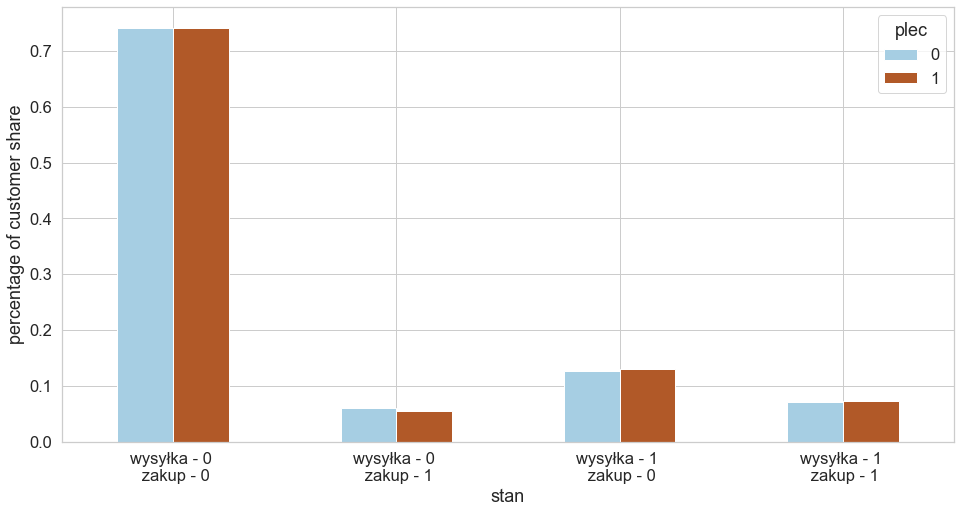


wyksztalcenie      brak  podstawowe  policealne   srednie    wyzsze
stan                                                               
00             0.794020    0.772663    0.805648  0.798035  0.528956
01             0.006645    0.004746    0.008306  0.007466  0.277146
10             0.192691    0.217845    0.176080  0.088605  0.106515
11             0.006645    0.004746    0.009967  0.105894  0.087384


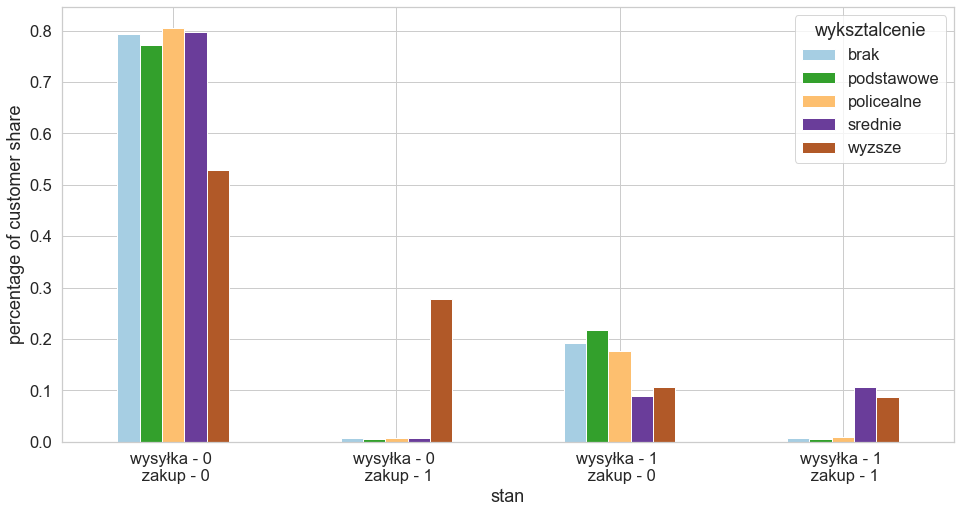


miejsce     m0_10  m100_500   m10_100     m_500      wies
stan                                                     
00       0.763894  0.712292  0.728128  0.632246  0.783721
01       0.038712  0.094352  0.071982  0.163949  0.012292
10       0.122652  0.076412  0.104651  0.110507  0.177409
11       0.074741  0.116944  0.095238  0.093297  0.026578


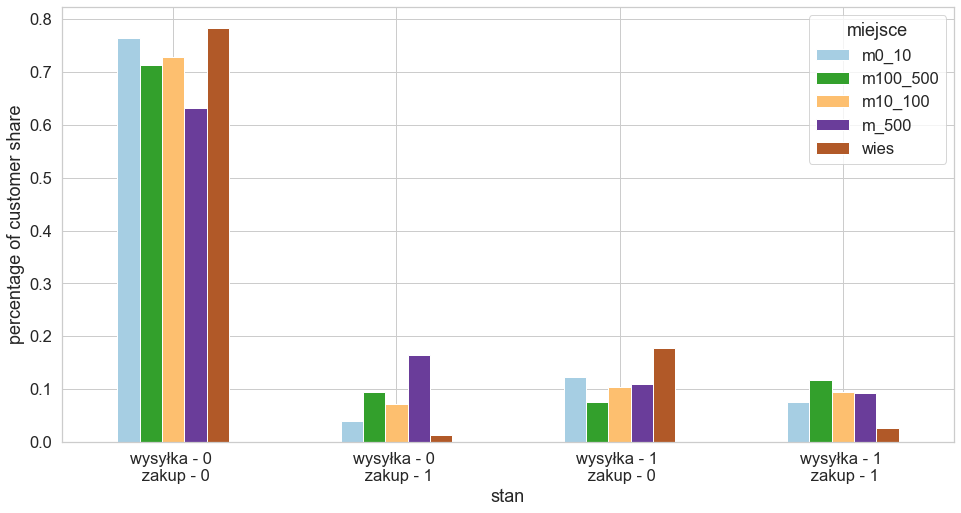


         18-26     27-30     31-40     41-50     51-60       65+
stan                                                            
00    0.719680  0.657784  0.715664  0.751327  0.779825  0.768022
01    0.065217  0.144460  0.095914  0.051041  0.027632  0.015712
10    0.083524  0.093969  0.108400  0.131074  0.150877  0.195009
11    0.131579  0.103787  0.080023  0.066558  0.041667  0.021257


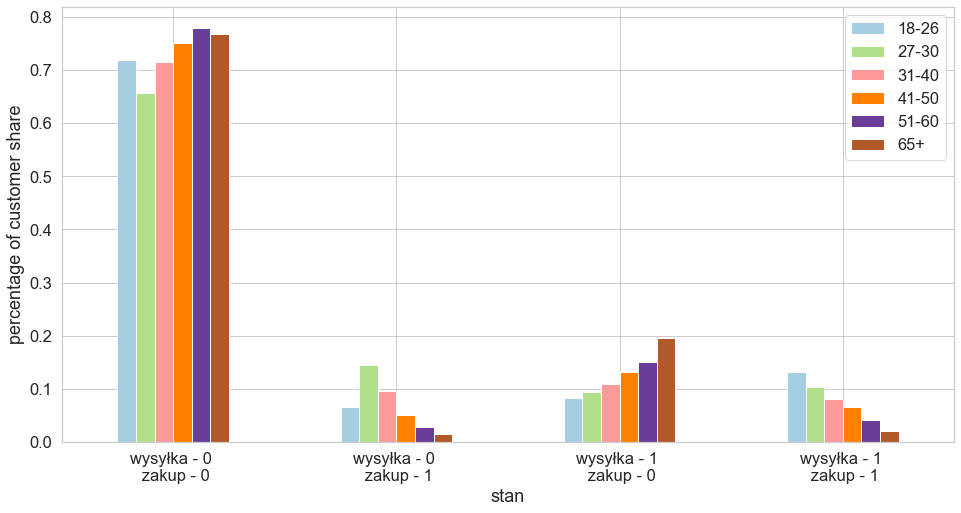


      zerowa kwota      1-50    51-100   101-200      200+
stan                                                      
00        0.718898  0.758508  0.738937  0.742320  0.722689
01        0.064577  0.031702  0.065962  0.064691  0.081933
10        0.139601  0.154312  0.125522  0.107698  0.111345
11        0.076923  0.055478  0.069580  0.085291  0.084034


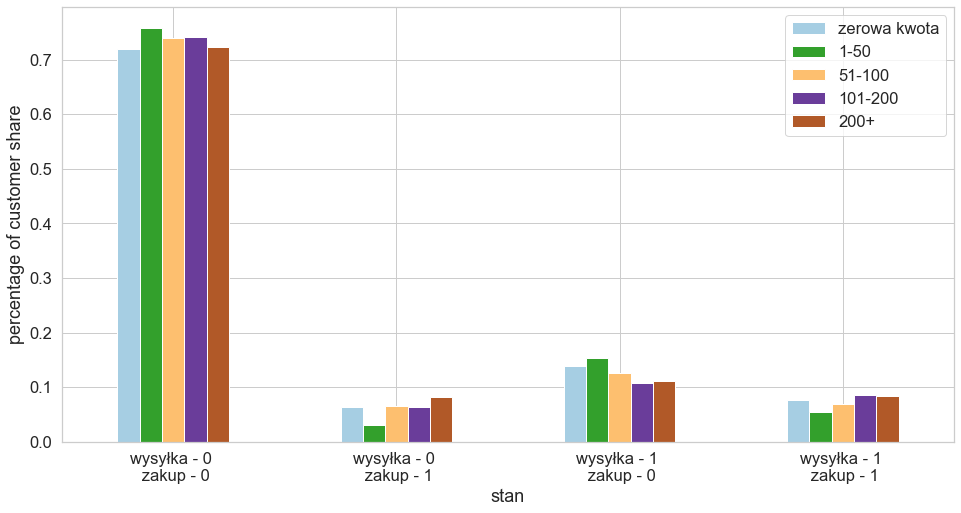


wojewodztwo     dolsl    kujpom      lodz     lubel  lubus     malop  \
stan                                                                   
00           0.739894  0.735450  0.764940  0.738532   0.66  0.742029   
01           0.059312  0.068783  0.051793  0.073394   0.08  0.057971   
10           0.126936  0.116402  0.123506  0.105505   0.16  0.133333   
11           0.073857  0.079365  0.059761  0.082569   0.10  0.066667   

wojewodztwo     mazow      opol    podkar    podlas      pomo      slas  \
stan                                                                      
00           0.769697  0.709091  0.737705  0.741379  0.735135  0.746867   
01           0.052525  0.100000  0.054645  0.086207  0.064865  0.052632   
10           0.109091  0.136364  0.158470  0.112069  0.113514  0.140351   
11           0.068687  0.054545  0.049180  0.060345  0.086486  0.060150   

wojewodztwo     swiet    warmaz   wielkop   zachpom  
stan                                                 
00     

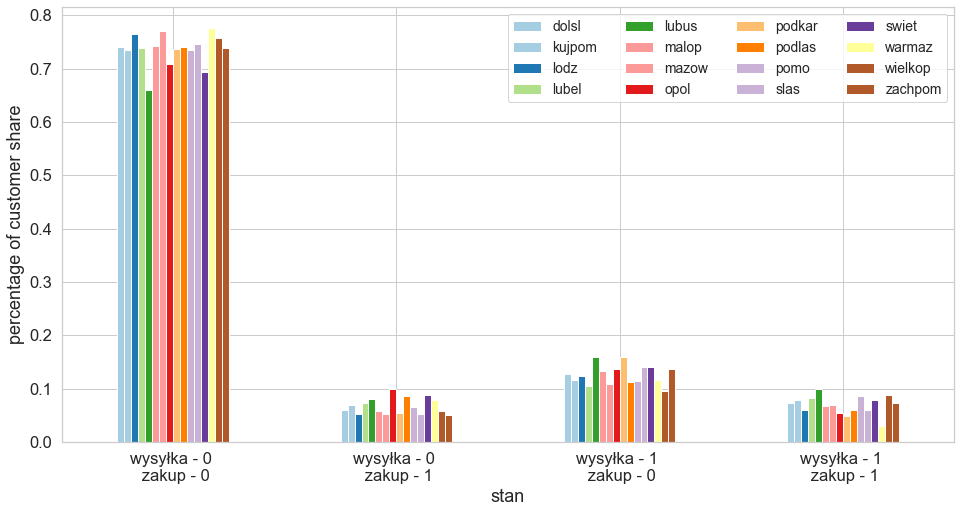


średni wynik dla grupy wysyłka-zakup(11) 0.069
średni wynik dla wysyłka-brak_zakupu (10) 0.13
średni wynik dla brak_wysyłki-zakup (01) 0.066


In [7]:
columns_for_stats=['plec','wyksztalcenie','miejsce','wiek_cat','kwota_cat','wojewodztwo']

mean_01=0
mean_11=0
mean_10=0
n_mean=0
for i in columns_for_stats:
    df=procentowy_udzial(i)

    mean_01 += df.loc['01',:].sum()
    mean_11 += df.loc['11',:].sum()
    mean_10 += df.loc['10',:].sum()
    n_mean += df.shape[1]

    print()
    
print('the mean value for the 11 group',round(mean_11/n_mean,3))
print('the mean value for the 10 group',round(mean_10/n_mean,3))
print('the mean value for the 01 group',round(mean_01/n_mean,3))

_Interpretation:_ Mean percentage share of customers that buy a product without receiving an advertisement is $ 6.6\% $. For people with higher education this share equals almost $ 30\% $. It means that people from this group (with higher education) are less likely to qualify for marketing campaign.

__Statistics of marketing campaign__

In [8]:
data.groupby(['zakup','wysylka_oferty']).size().unstack()

wysylka_oferty,0,1
zakup,,
0,7437,1280
1,591,726


Advertisement offer was sent to 2006 customers where 726 of them purchased a product. Efficiency of campaign is 36\%

### 3. Selecting the best algorithm

In this subsection the best algorithm is selected for further work. Performance of a method is evaluated with confusion matrix. Five methods are tested: Decision Tree Classifier, Support Vector Classifier, Random Forest Classifier, Logistic Regression, K-Nearest-Neighbors.
<br> Education, city and voivodeship are transformed to numeric type using the _LabelEncoder_ function

In [9]:
data_le=data.copy()
le_wyk=LabelEncoder()
le_miej=LabelEncoder()
le_woj=LabelEncoder()

modele=[le_wyk,le_miej,le_woj]
kolumny_do_zmiany=['wyksztalcenie','miejsce','wojewodztwo']
for i,model in zip(kolumny_do_zmiany,modele):
    data_le[i]=model.fit_transform(data_le[i])

data_le.head(10)

,wiek,plec,wyksztalcenie,miejsce,kwota,wojewodztwo,wysylka_oferty,zakup,wiek_cat,kwota_cat,stan
numer,,,,,,,,,,,
1,32,1,3,4,110.810558,0,0,0,3,4,00
2,26,1,4,1,100.857513,15,0,0,1,4,00
3,20,0,3,1,66.199017,15,0,0,1,3,00
4,18,1,2,1,77.017056,11,1,0,1,3,10
5,26,1,3,1,137.221167,15,0,0,1,4,00
...,...,...,...,...,...,...,...,...,...,...,...
10030,66,0,3,0,43.382445,2,0,0,6,2,00
10031,68,0,1,4,135.049376,15,0,0,6,4,00
10032,59,0,3,4,33.451280,6,0,0,5,2,00


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

kol_do_usuniecia= ['zakup','stan','wiek_cat','kwota_cat']
X_le=data_le.drop(columns=kol_do_usuniecia)
y_le=data_le['zakup']

Decision Tree Classifier

In [11]:
model=DecisionTreeClassifier(max_depth=15)
model.fit(X_le,y_le)
cm=pd.DataFrame(confusion_matrix(y_le,model.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8568,149
1,155,1162


Support Vector Classifier

In [12]:
model=SVC(C=10,kernel='poly',degree=2)
model.fit(X_le,y_le)
cm=pd.DataFrame(confusion_matrix(y_le,model.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8717,0
1,1317,0


In [13]:
model=SVC(C=10,kernel='rbf',gamma=100)
model.fit(X_le,y_le)

cm=pd.DataFrame(confusion_matrix(y_le,model.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8717,0
1,10,1307


Random Forest Classifier

In [14]:
rfc=RandomForestClassifier(n_estimators=500,max_features=6)
rfc.fit(X_le,y_le)
cm=pd.DataFrame(confusion_matrix(y_le,rfc.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8713,4
1,6,1311


Logistic Regression

In [15]:
lr_le=LogisticRegression(max_iter=1000000)
lr_le.fit(X_le,y_le)

cm=pd.DataFrame(confusion_matrix(y_le,lr_le.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8432,285
1,913,404


KNN

In [16]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_le,y_le)
cm=pd.DataFrame(confusion_matrix(y_le,knn.predict(X_le)))
cm.index.name='True'
cm.columns.name='Predicted'
cm

Predicted,0,1
True,,
0,8696,21
1,1270,47


The best metohods are RandomForestClassifier and SupportVectorClassifier with 'rbf' kernel. The former one is selected for further analysis.

In [17]:
model_final=RandomForestClassifier(max_features = 6, n_estimators = 500)
# model_final=SVC(C=100,kernel='rbf',gamma=1,probability=True)
model_final.fit(X_le,y_le)

RandomForestClassifier(max_features=6, n_estimators=500)

### 4. Uplifting modelling

In this section customers from the target database are selected for marketing campaign. The process of selection is conducted as follows: using the selected method (RandomForestClassifier) two cases are considered: 
- the first case where no customer receives advertisement 
- the second case where all of the customers receive advertisement.

For each case two probabilites are calculated: probability that a customer will not buy a product and probability that a customer will buy a product. In other words probability for every case (00,01,10,11) is calculated. From the seller point of view his target are people for whom the probability of not purchasing a product without ad and the probability of purchasing a product after receiving ad is very high (these people are worth sending ads). 

preparing the target database

In [18]:
data_final = pd.read_csv('klienci_final.txt',sep=",",header=0,encoding='unicode_escape')
data_final.set_index('numer',drop=True,inplace=True)
data_final['wojewodztwo']=data_final['wojewodztwo'].str.replace('³','l').str.replace('¹','a').str.replace('ó','o').str.replace('ê','e')
data_final.head()

,wiek,plec,wyksztalcenie,miejsce,kwota,wojewodztwo
numer,,,,,,
1,35,0,podstawowe,wies,97.965209,zachpom
2,26,1,podstawowe,wies,38.377882,dolsl
3,31,0,srednie,m10_100,136.401297,dolsl
4,25,0,policealne,m100_500,118.728067,dolsl
5,18,1,srednie,m_500,79.311481,dolsl


In [19]:
data_final2=data_final.copy()

modele=[le_wyk,le_miej,le_woj]
kolumny_do_zmiany=['wyksztalcenie','miejsce','wojewodztwo']
for i,model in zip(kolumny_do_zmiany,modele):
    data_final2[i]=model.transform(data_final[i])
    
X_final=data_final2

Calculating the probabilities for the two cases mentioned in the subsection description

In [49]:
# vector 'wysylka_oferty' consisting of zeros
zakup0=np.zeros(X_final.shape[0])
# vector 'wysylka_oferty' consisting of ones
zakup1=np.ones(X_final.shape[0])

#predicting results for zeros vector
wynik_zera=model_final.predict_proba( np.hstack((X_final.values,zakup0.reshape(-1,1))).reshape(-1,7))

#predicting results for ones vector
wynik_jedynki=model_final.predict_proba( np.hstack((X_final.values,zakup1.reshape(-1,1))).reshape(-1,7))

Created dataframe consists of seven columns:
1. vector of zeros (the first case where no one gets ad)
2. probability of purchase for the first case
3. probability of no purchase for the first case
4. vector of ones (the second case where everyone gets ad)
5. probability of purchase for the second case
6. probability of no purchase for the second case
7. uplift value given with the formula: $ uplift = 00 + 11 - 01 - 10 $

In [50]:
df=pd.DataFrame(columns=['vec0','purchase0','no_purchase0','vec1','purchase1','no_purchase1'],index=X_final.index)
df['vec0']=zakup0.astype(int)
df['vec1']=zakup1.astype(int)
df['purchase0']=wynik_zera[:,1]
df['no_purchase0']=wynik_zera[:,0]
df['purchase1']=wynik_jedynki[:,1]
df['no_purchase1']=wynik_jedynki[:,0]

df['uplift']=df.iloc[:,2]+df.iloc[:,4]-df.iloc[:,1]-df.iloc[:,5]
df.head(10)

,vec0,purchase0,no_purchase0,vec1,purchase1,no_purchase1,uplift
numer,,,,,,,
1,0,0.016,0.984,1,0.008000,0.992000,-0.016000
2,0,0.162,0.838,1,0.002000,0.998000,-0.320000
3,0,0.000,1.000,1,0.538000,0.462000,1.076000
4,0,0.052,0.948,1,0.202000,0.798000,0.300000
5,0,0.000,1.000,1,0.712667,0.287333,1.425333
6,0,0.004,0.996,1,0.072000,0.928000,0.136000
7,0,0.004,0.996,1,0.968000,0.032000,1.928000
8,0,0.000,1.000,1,0.934000,0.066000,1.868000
9,0,0.044,0.956,1,0.800000,0.200000,1.512000


It should be emphasized that uplift parameter is not very meaningful. For example for number 4 its value is positive (0.388) whereas probability of buying a product after receiving ad equals only 23.8\%. The author concluded that the most reliable is situation where 00 > 50% and 11 > 50%. It means that it is more probable that a customer will not buy a product without ad and he will buy it after receiving ad.


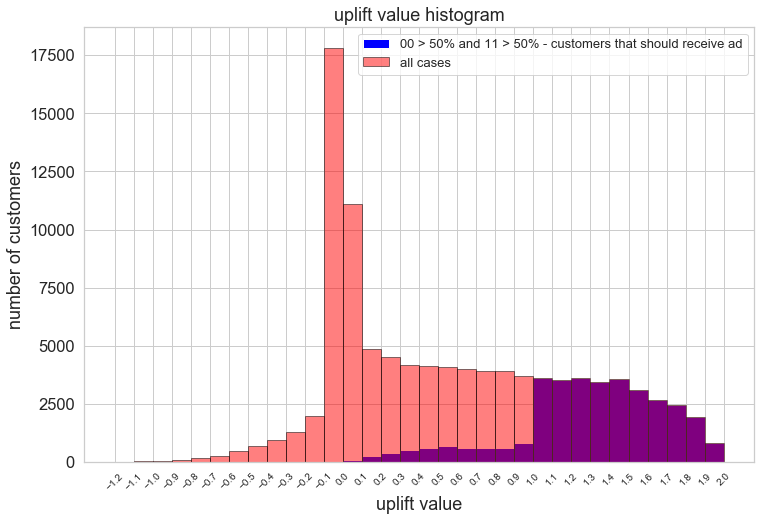

In [47]:
mask00=df['brak_zakupu0']>0.5
mask11=df['zakup1']>0.5

df[mask00 & mask11]['uplift'].plot(kind='hist',bins=np.arange(-1.2,2.1,0.1), figsize=(12,8),align='mid',color='blue',alpha=1)
df['uplift'].plot(kind='hist',bins=np.arange(-1.2,2.1,0.1), figsize=(12,8),align='mid',color='red',alpha=0.5,ec='black')
plt.xticks(ticks=np.arange(-1.2,2.1,0.1),fontsize=10,rotation=45)
plt.xlabel('uplift value')
plt.ylabel('number of customers')
plt.title('uplift value histogram')
plt.legend(['00 > 50% and 11 > 50% - customers that should receive ad','all cases'], fontsize=13)
plt.show()

Dataframe for calculating a protif

In [51]:
#zakup0 < 0.5 i zakup1>0.5
df2=df.copy()
df2['offer_final_decision']=df2.apply(lambda x: 1 if ( (x['purchase0']<=0.5) and (x['purchase1']>0.5)) else 0,axis=1)
df2['purchase_final_decision_proba']=model_final.predict_proba(np.hstack((X_final.values,df2['offer_final_decision'].values.reshape(-1,1))).reshape(-1,7) )[:,1]
df2['purchase_final_decision']=df2['purchase_final_decision_proba'].apply(lambda x: 1 if x>0.5 else 0)
zysk_uplift2=df2['offer_final_decision'].sum()*(-10)+df2['purchase_final_decision'].sum()*100
df2


,vec0,purchase0,no_purchase0,vec1,purchase1,no_purchase1,uplift,offer_final_decision,purchase_final_decision_proba,purchase_final_decision
numer,,,,,,,,,,
1,0,0.016,0.984,1,0.008000,0.992000,-0.016000,0,0.016000,0
2,0,0.162,0.838,1,0.002000,0.998000,-0.320000,0,0.162000,0
3,0,0.000,1.000,1,0.538000,0.462000,1.076000,1,0.538000,1
4,0,0.052,0.948,1,0.202000,0.798000,0.300000,0,0.052000,0
5,0,0.000,1.000,1,0.712667,0.287333,1.425333,1,0.712667,1
...,...,...,...,...,...,...,...,...,...,...
100891,0,0.018,0.982,1,0.516000,0.484000,0.996000,1,0.516000,1
100892,0,0.000,1.000,1,0.452000,0.548000,0.904000,0,0.000000,0
100893,0,0.000,1.000,1,0.000000,1.000000,0.000000,0,0.000000,0


Predicted profits for three vectors: zeros vector (no one gets ad), ones vector (everyone gets ad) and calculated vector

In [52]:
profit0=df2[df2['purchase0']>0.5]['purchase0'].sum()*100
profit1=df2[df2['purchase1']>0.5]['purchase1'].sum()*100-df2.shape[0]*10
profit_opt=df2['purchase_final_decision'].sum()*100-df2['offer_final_decision'].sum()*10

pd.DataFrame(np.array([profit0,profit1,profit_opt],dtype=int),columns=['profit'],index=['vec0','vec1','vec_opt'])

,profit
vec0,292215
vec1,1551733
vec_opt,3507230


Note: The final decision of the target database customers are unknown. Selected algorithm is sure to misclassifiy some customers decisions. Nevertheless by looking at the predicted profit (above) one can conclude that uplifting modelling makes sense and can significantly increase earned money.